In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from preprocessing import *

In [2]:
train_df, valid_df, test_df = get_datasets()
print("Number of samples: {} for training, {} for validation, {} for testing.".format(
    len(train_df), len(valid_df), len(test_df)))
    

Number of samples: 1021 for training, 439 for validation, 1459 for testing.


In [3]:
train_df = preprocess_dataset(train_df)
valid_df = preprocess_dataset(valid_df)
test_df = preprocess_dataset(test_df, is_testing=True)

In [4]:
train_df.to_csv(PROCESSED_DATA_PATH+'train_processed.csv')
valid_df.to_csv(PROCESSED_DATA_PATH+'valid_processed.csv')
test_df.to_csv(PROCESSED_DATA_PATH+'test_processed.csv')

In [5]:
train_df, valid_df, test_df = get_processed_datasets()
train_df.isna().any().any(), valid_df.isna().any().any(), test_df.isna().any().any()

(False, False, False)

In [6]:
train_df, valid_df, test_df = replace_category_with_dummy_datasets(train_df, valid_df, test_df)

In [7]:
train_df.to_csv(PROCESSED_DATA_PATH+'train_processed_with_dummies.csv')
valid_df.to_csv(PROCESSED_DATA_PATH+'valid_processed_with_dummies.csv')
test_df.to_csv(PROCESSED_DATA_PATH+'test_processed_with_dummies.csv')

In [7]:
import statsmodels.api as sm
y = train_df['SalePrice']
X = train_df.drop(columns='SalePrice').copy()
model = sm.OLS(y, X)

In [12]:
res = model.fit()
print(res.summary())
pd.DataFrame(res.summary().tables[1]).to_csv('./solution/simple_ols_summary.csv')

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                              290.0
Date:                Tue, 26 Mar 2024   Prob (F-statistic):                        0.00
Time:                        20:31:11   Log-Likelihood:                         -11675.
No. Observations:                1021   AIC:                                  2.379e+04
Df Residuals:                     802   BIC:                                  2.487e+04
Df Model:                         219                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [13]:
train_predict = res.predict(train_df.drop(columns='SalePrice'))
valid_predict = res.predict(valid_df.drop(columns='SalePrice'))
test_predict = res.predict(test_df)
pd.DataFrame({'Id': test_df.index, 'SalePrice': test_predict}).to_csv('./solution/simple_ols_submit.csv', index=False)

In [19]:
from statsmodels.tools.eval_measures import rmse
rmse(train_df.SalePrice, train_predict, axis=0), rmse(valid_df.SalePrice, valid_predict, axis=0)

(22389.160956031214, 27436.711674970953)

Text(0.5, 1.0, 'Simple OLS with Training data\nTrue vs Predicted Sale Price')

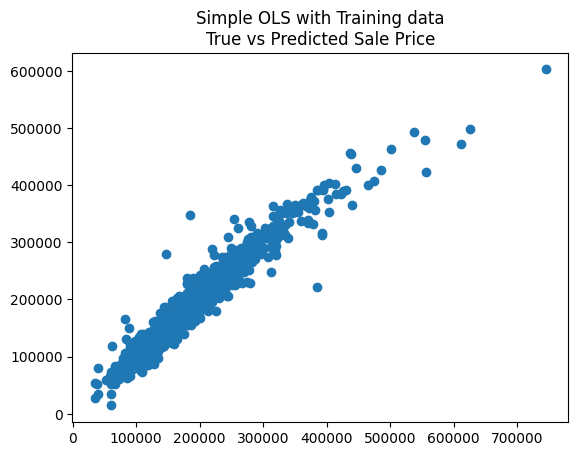

In [14]:
plt.scatter(train_df['SalePrice'], train_predict)
plt.title('Simple OLS with Training data\nTrue vs Predicted Sale Price')

Text(0.5, 1.0, 'Simple OLS with Validation data\nTrue vs Predicted Sale Price')

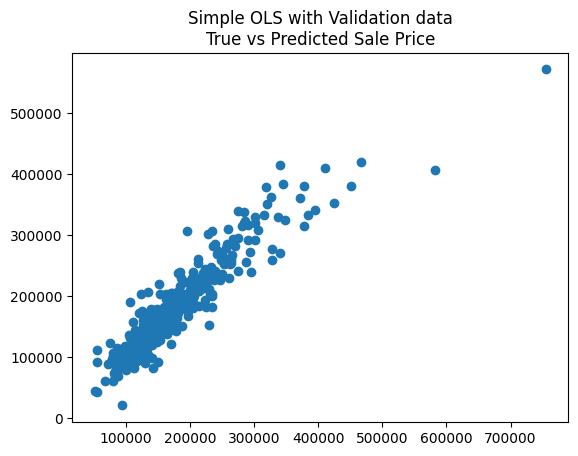

In [15]:
plt.scatter(valid_df['SalePrice'], valid_predict)
plt.title('Simple OLS with Validation data\nTrue vs Predicted Sale Price')